# CLASSIFICATION OF LAB SAMPLES

This notebook analyzes the accuracy of the SVM classifier on the training data and on lab samples.
The training data are:
* all genes (not just regulators);
* averaged;
* do not include T1 (since only one observtion)

# TO DO
1. compare accuracy with ranom selection of genes
1. Classifier coefficient profile.
   1. Eliza genes - 1-10
   1. Auto selected genes: 5, 10, 20

# Preliminaries

## Imports

In [1]:
import init
from common import constants as cn
from common.trinary_data import TrinaryData
from common.data_provider import DataProvider
from common import trinary_data
from common_python.plots import util_plots
from common_python.classifier import classifier_ensemble
from common_python.classifier import classifier_collection
from common import transform_data

import collections
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import cross_val_score
import seaborn as sns

%matplotlib inline

## Constants

In [2]:
PROVIDER = DataProvider()
PROVIDER.do()
DATA = TrinaryData(is_regulator=False, is_dropT1=True, is_averaged=True)
DF_X = DATA.df_X.copy()
ser_y = DATA.ser_y
value_dct = {0:4, 1:0, 3:1, 4:2, 2:3}
new_ys = [value_dct[i] for i in ser_y.values]
SER_Y = pd.Series(new_ys)
SER_Y.index = ser_y.index
#SER_Y = ser_y
STAGE_NAMES = PROVIDER.getStageNames(SER_Y)

In [3]:
[STAGE_NAMES[i] for i in SER_Y]

['Transition',
 'Transition',
 'Transition',
 'Transition',
 'Transition',
 'Transition',
 'StageII',
 'StageII',
 'Stage1a',
 'StageII',
 'Stage1a',
 'Stage1a',
 'Stage1a',
 'Stage1a',
 'Stage1b',
 'Stage1b',
 'Stage1b',
 'StageII',
 'StageII',
 'StageII',
 'Resuscitation',
 'Resuscitation',
 'Resuscitation',
 'Resuscitation']

In [4]:
ELIZA_COLUMNS = ["Rv3841",
"Rv2377c",
"Rv2378c",
"Rv2379c",
"Rv2380c",
"Rv2381c",
"Rv2382c",
"Rv2383c",
"Rv2384",
"Rv2385",
"Rv2386c",
]
DF_X = DF_X[ELIZA_COLUMNS]

In [5]:
CLASSIFIER = classifier_ensemble.ClassifierEnsemble(
        classifier_ensemble.ClassifierDescriptorSVM(), filter_high_rank=10, size=100)
CLASSIFIER.fit(DF_X, SER_Y)

In [6]:
# GO Terms for the genes
df_go_terms = PROVIDER.df_go_terms.set_index("GENE_ID")
for gene in CLASSIFIER.features:
    if gene in df_go_terms.index:
        print("%s: %s" % (gene, df_go_terms.loc[gene, "GO_Term"]))

Rv2385: triglyceride lipase activity
Rv2386c: tryptophan biosynthetic process---cellular response to ironstarvation---siderophore biosynthetic process from catechol---growth---response-to-host-immune-response---magnesium ion binding---anthranilate synthase activity---chorismate mutase activity---plasma membrane---anthranilate synthase complex
Rv3841: response to hypoxia---iron assimilation by chelation and transport---response to nitrosative stress---ferroxidase activity---iron ion binding---extracellular region---cell wall---cytosol---plasma membrane
Rv2384: cellular response to ironstarvation---siderophore biosynthetic process from catechol---acid-amino acid ligase activity
Rv2382c: growth
Rv2379c: cell wall---cytosol---plasma membrane
Rv2378c: siderophore biosynthetic process from catechol---growth
Rv2383c: pathogenesis---cellular response to ironstarvation---siderophore biosynthetic process from catechol---response-to-host-immune-response---acyl carrier activity---protein binding--

## Helper Functions

In [7]:
def getStage(states):
    """
    Provides the name of the stage for the value of a state.
    
    Parameters
    ----------
    states: list-int
    """
    timepoints = []
    for state in states:
        timepoint = [i for i, v in SER_Y.iteritems() if v == state][0]
        timepoints.append(timepoint)
    return list(PROVIDER.getStages(timepoints))

# TESTS
assert(getStage([0, 1])[0] == "Transition")

In [8]:
def plotExpressionLevels(df_X, features, ser_y=None, is_plot=True, title=""):
    """
    Heat map of expression levels. Shades states.
    
    Parameters
    ----------
    df_X: DataFrame (feature vector)
    features: list-str
    """
    # Internal constants
    ROTATION = 30
    FONTSIZE = 14
    # Shade replications
    fig, ax = plt.subplots(1, figsize=(20, 5))
    columns = list(features)
    columns.sort()
    new_df_X = df_X[columns]
    sns.heatmap(new_df_X.T, cmap="seismic", ax=ax)
    # Shade the classes
    if ser_y is not None:
        alphas = [0.0, 0.4]
        alpha_idx = 0
        for idx, val in enumerate(ser_y.values):
            stage = getStage([val])[0]
            if (idx == 0):
                ax.text(idx, 0, "%s" % stage, fontsize=FONTSIZE, rotation=ROTATION)
            elif ser_y.values[idx-1] != val:
                ax.text(idx, 0, "%s" % stage, fontsize=FONTSIZE, rotation=ROTATION)
                alpha_idx = 1 - alpha_idx
            ax.axvspan(idx, idx+1, facecolor='grey', alpha=alphas[alpha_idx])
    # Other plot characteristics
    ax.set_title(title, fontsize=18)
    #
    if is_plot:
        plt.show()
    else:
        plt.close()
    
# Tests
plotExpressionLevels(DF_X, CLASSIFIER.features, SER_Y, is_plot=False)

In [9]:
def sortColumns(df):
    columns = list(df.columns)
    columns.sort()
    df.columns = columns
    df = df.sort_index()
    return df

In [10]:
def getSampleData(**kwargs):
    sample_data = trinary_data.getSampleData(**kwargs)
    dct = {}
    for sample in trinary_data.SAMPLES:
        dct[sample] = sortColumns(sample_data.__getattribute__(sample))
    return dct
        
SAMPLE_BIOREACTOR_REF_DCT = getSampleData(is_regulator=False, is_bioreactor_ref=True)
SAMPLE_NOTBIOREACTOR_REF_DCT = getSampleData(is_regulator=False, is_bioreactor_ref=False)

## Data

### BioReactor

In [11]:
DF_X.head(2)

,Rv3841,Rv2377c,Rv2378c,Rv2379c,Rv2380c,Rv2381c,Rv2382c,Rv2383c,Rv2384,Rv2385,Rv2386c
T2,1,0,0,0,0,-1,-1,-1,-1,-1,-1
T3,1,0,0,-1,0,-1,-1,-1,-1,-1,-1


In [12]:
SER_Y.head(2)

timepoint
T2    0
T3    0
dtype: int64

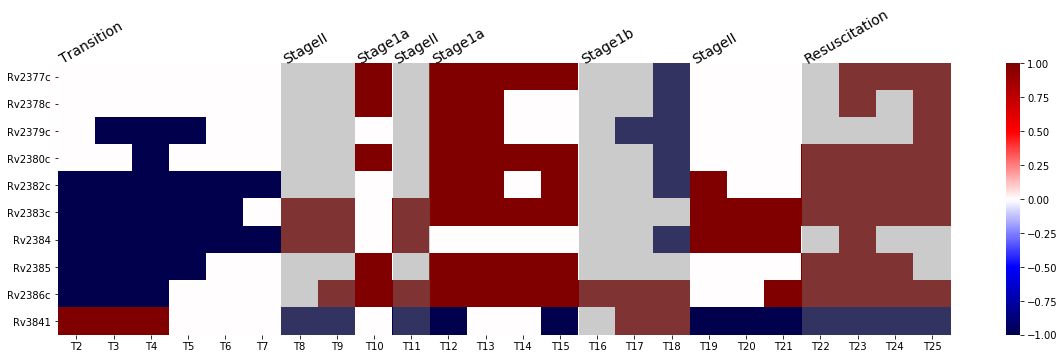

In [13]:
# Deeper look at training data
plotExpressionLevels(DATA.df_X, CLASSIFIER.features, ser_y=SER_Y, title="")

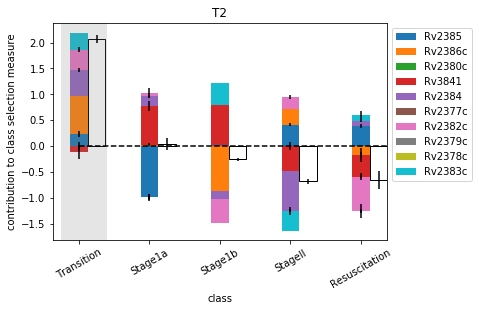

In [14]:
instances = ["T2"]
for instance in instances:
    CLASSIFIER.plotFeatureContributions(DF_X.loc[instance, :],
                    title=instance, true_class=SER_Y.loc[instance],
                    class_names=STAGE_NAMES)

**FIXME**: Axis should go in sequence of stages

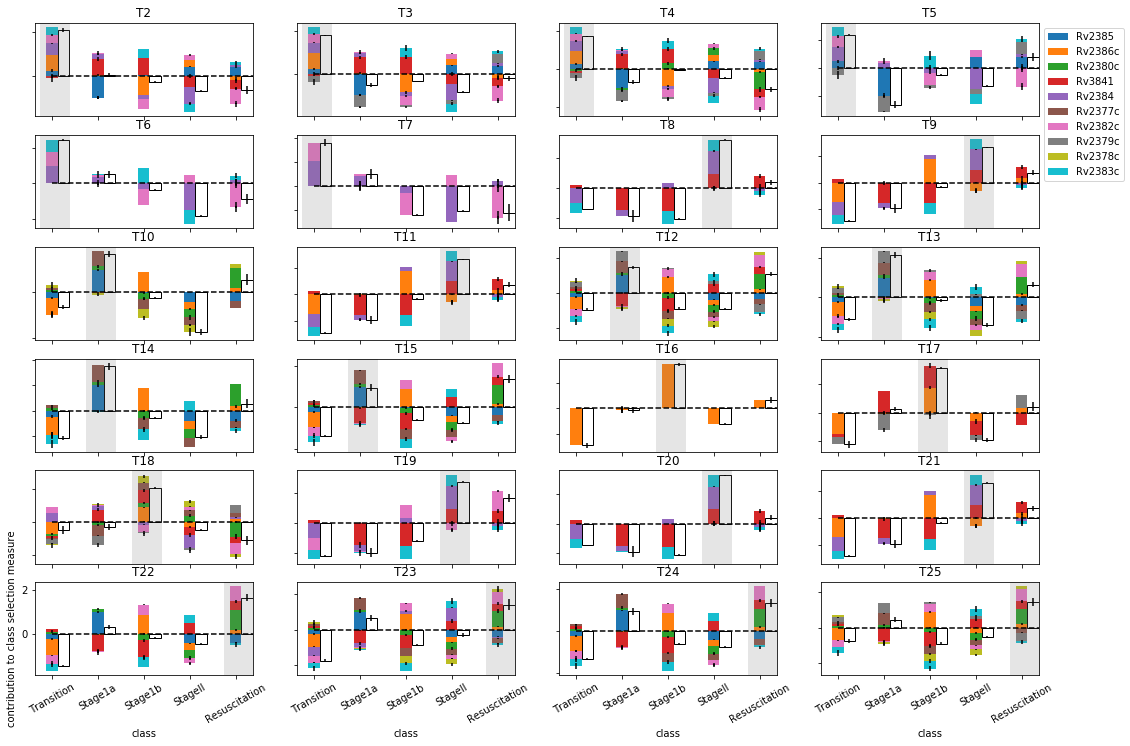

In [32]:
nrow = 6
ncol = 4
_, axes = plt.subplots(nrow, ncol, figsize=(18,12))
for irow in range(nrow):
    for icol in range(ncol):
        ax = axes[irow, icol]
        instance_num = irow*ncol + icol + 2
        instance = "T%d" % instance_num
        if instance not in DATA.df_X.index:
            break
        ser_X = DATA.df_X.loc[instance, :]
        if (icol + 1 == ncol) and (irow==0):
            is_legend = True
        else:
            is_legend = False
        if (irow + 1 == nrow):
            is_xlabel = True
            if icol == 0:
                is_ylabel = True
            else:
                is_ylabel = False
        else:
            is_ylabel = False
            is_xlabel = False
        CLASSIFIER.plotFeatureContributions(ser_X, ax=ax,
                title=instance, true_class=SER_Y.loc[instance], is_plot=False, is_legend=is_legend,
                                           class_names=STAGE_NAMES,
                                           is_xlabel=is_xlabel, is_ylabel=is_ylabel)
plt.show()

### Lab Samples

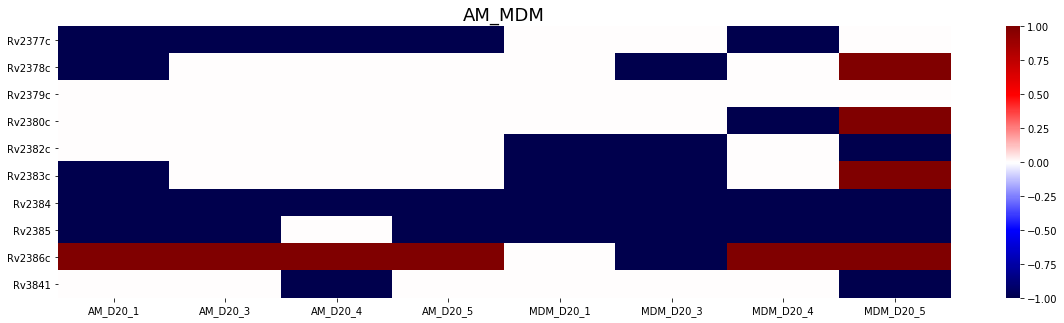

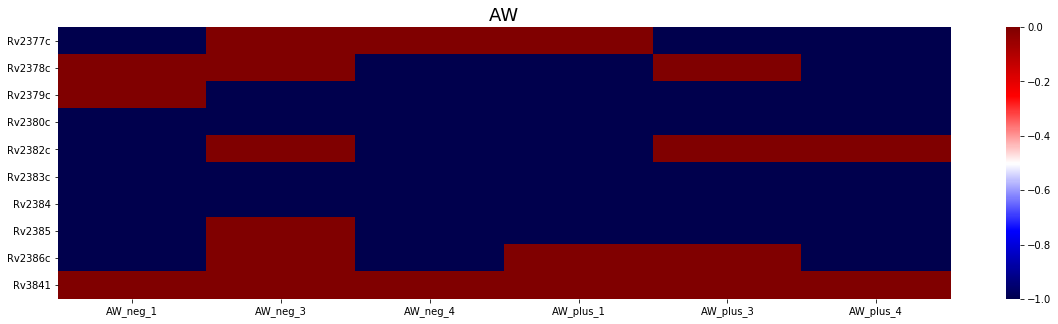

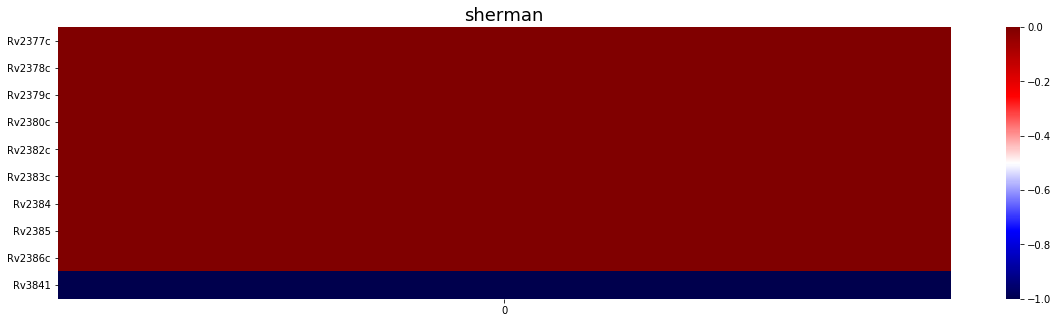

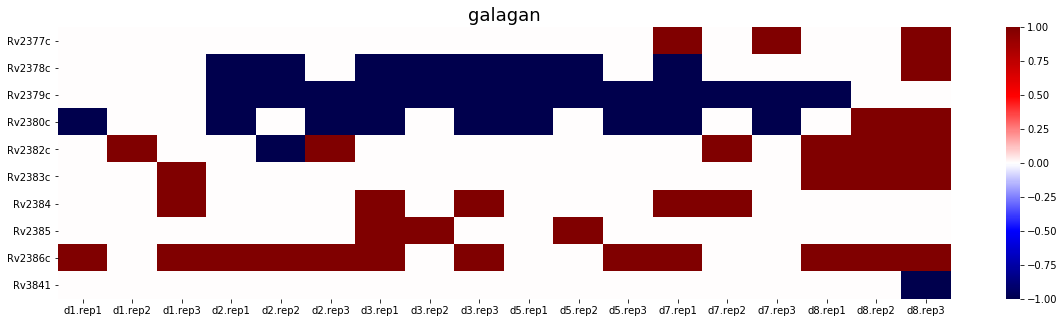

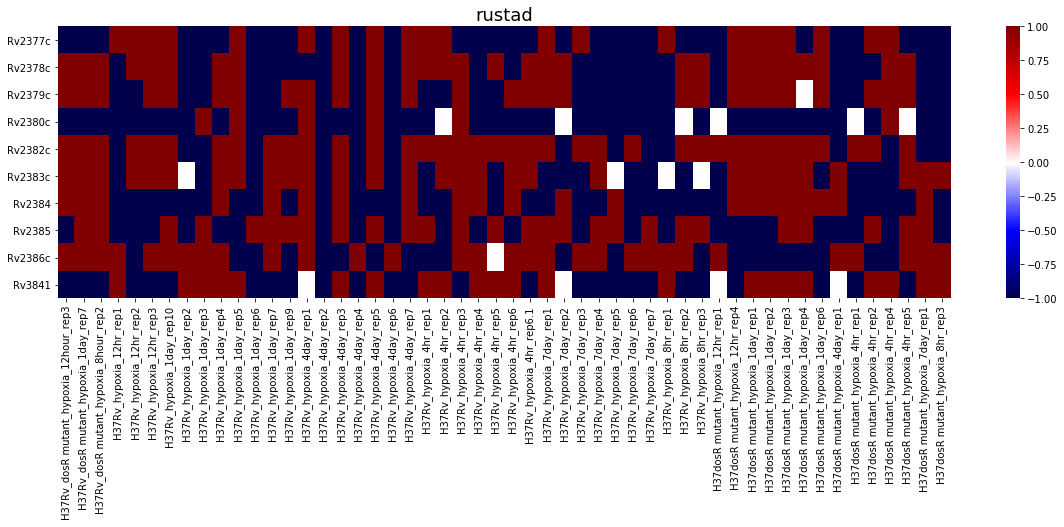

In [16]:
for sample in trinary_data.SAMPLES:
    plotExpressionLevels(SAMPLE_BIOREACTOR_REF_DCT[sample], CLASSIFIER.features, title=sample)

# Classification Validations on Training Samples
Classify T2-T25 and see if result is same as original class. Use 5-fold cross validation, where there is a holdout for each class and the selection is random.


In [17]:
if Tr:
    accuracy_dct = {}
    ranks = [1, 2, 4, 8, 16, 32, 64, 128, 256]
    ranks = [1, 2, 4, 6, 8, 10]
    for rank in ranks:
        accuracy_dct[rank] = classifier_ensemble.ClassifierEnsemble.crossValidate(
            DATA, num_iter=10, num_holdout=1, filter_high_rank=rank, size=20)
    plt.plot(list(accuracy_dct.keys()), list(accuracy_dct.values()))
    plt.ylim([0, 1.1])
    _ = plt.xlabel("No genes in clasifier")
    _ = plt.ylabel("accuracy")

# Classification of Samples

In [18]:
CLASSIFIER.features

['Rv2385',
 'Rv2386c',
 'Rv2380c',
 'Rv3841',
 'Rv2384',
 'Rv2377c',
 'Rv2382c',
 'Rv2379c',
 'Rv2378c',
 'Rv2383c']

In [19]:
CLASSIFIER.predict(SAMPLE_BIOREACTOR_REF_DCT["AM_MDM"])

,0,1,2,3,4
AM_D20_1,0.00,0.0,1.00,0.0,0.00
AM_D20_3,0.00,0.0,0.95,0.0,0.05
AM_D20_4,0.06,0.0,0.43,0.0,0.51
AM_D20_5,0.00,0.0,0.95,0.0,0.05
MDM_D20_1,1.00,0.0,0.00,0.0,0.00
MDM_D20_3,1.00,0.0,0.00,0.0,0.00
MDM_D20_4,0.00,0.0,1.00,0.0,0.00
MDM_D20_5,0.77,0.0,0.00,0.0,0.23


In [20]:
CLASSIFIER.predict(SAMPLE_NOTBIOREACTOR_REF_DCT["AM_MDM"])

,0,1,2,3,4
AM_D20_1,1.00,0.00,0.0,0.00,0.0
MDM_D20_1,1.00,0.00,0.0,0.00,0.0
MDM_D20_3,1.00,0.00,0.0,0.00,0.0
MDM_D20_4,0.05,0.00,0.0,0.95,0.0
MDM_D20_5,0.92,0.08,0.0,0.00,0.0


In [21]:
# Combine states - 0 + 4 == neg; 1,2,3 = pos
# Use uncurated baseline for AW, others?

In [22]:
def reportSamplePredictions(sample_dct):
    for sample, df_X in sample_dct.items():
        print("\n\n%s" % sample)
        df = CLASSIFIER.predict(df_X)
        df.columns = STAGE_NAMES[np.array(df.columns)]
        ordered_columns = ["Transition", "Stage1a", "Stage1b", "StageII", "Resuscitation"]
        df = df[ordered_columns]
        print(df)

In [23]:
reportSamplePredictions(SAMPLE_NOTBIOREACTOR_REF_DCT)



AM_MDM
           Transition  Stage1a  Stage1b  StageII  Resuscitation
AM_D20_1         1.00     0.00      0.0     0.00            0.0
MDM_D20_1        1.00     0.00      0.0     0.00            0.0
MDM_D20_3        1.00     0.00      0.0     0.00            0.0
MDM_D20_4        0.05     0.00      0.0     0.95            0.0
MDM_D20_5        0.92     0.08      0.0     0.00            0.0


AW
           Transition  Stage1a  Stage1b  StageII  Resuscitation
AW_neg_1         1.00      0.0      0.0     0.00           0.00
AW_plus_1        0.05      0.0      0.0     0.95           0.00
AW_plus_3        0.00      0.0      0.0     1.00           0.00
AW_plus_4        0.95      0.0      0.0     0.00           0.05


sherman
   Transition  Stage1a  Stage1b  StageII  Resuscitation
0         0.0      0.0      0.0      1.0            0.0


galagan
***Warning: missing columns in prediction vector. 
 ['Rv2379c', 'Rv2385', 'Rv2383c', 'Rv3841', 'Rv2378c', 'Rv2382c', 'Rv2384', 'Rv2386c']
         Tra

In [24]:
reportSamplePredictions(SAMPLE_BIOREACTOR_REF_DCT)



AM_MDM
           Transition  Stage1a  Stage1b  StageII  Resuscitation
AM_D20_1         0.00      0.0     1.00      0.0           0.00
AM_D20_3         0.00      0.0     0.95      0.0           0.05
AM_D20_4         0.06      0.0     0.43      0.0           0.51
AM_D20_5         0.00      0.0     0.95      0.0           0.05
MDM_D20_1        1.00      0.0     0.00      0.0           0.00
MDM_D20_3        1.00      0.0     0.00      0.0           0.00
MDM_D20_4        0.00      0.0     1.00      0.0           0.00
MDM_D20_5        0.77      0.0     0.00      0.0           0.23


AW
           Transition  Stage1a  Stage1b  StageII  Resuscitation
AW_neg_1         1.00      0.0     0.00      0.0            0.0
AW_neg_3         1.00      0.0     0.00      0.0            0.0
AW_neg_4         1.00      0.0     0.00      0.0            0.0
AW_plus_1        1.00      0.0     0.00      0.0            0.0
AW_plus_3        0.91      0.0     0.09      0.0            0.0
AW_plus_4        1.00     

# Detailed Analyses

## Rustad

In [25]:
# Rustad analysis
df_X = SAMPLE_BIOREACTOR_REF_DCT["rustad"]
df_pred = CLASSIFIER.predict(df_X)
instances = [i for i in df_pred.index if "H37Rv_hypoxia" in i]
df_pred = df_pred.loc[instances, :]
times = []
replications = []
for instance in instances:
    if "hr" in instance:
        pos = instance.index("hr_")
    else:
        pos = instance.index("ay_")
    last_pos = pos + 2
    times.append(instance[0:last_pos])
    if "10" in instance:
        replications.append(instance[-2:])
    else:
        replications.append(instance[-1])
timeArr = np.array(times)
replicationArr = np.array(replications)
indexArr = list(df_pred.index)
indexArr = np.array(indexArr)
#
state_dct = {}
for time in set(times):
    idxs = [p for p, i in enumerate(indexArr) if time in i]
    replications_sub = replicationArr[idxs]
    times_sub = timeArr[idxs]
    state_dct[time] = []
    for instance in indexArr[idxs]:
        max_val = np.max(df_pred.loc[instance, :].values)
        state = [s for s in df_pred.columns if df_pred.loc[instance, s] == max_val][0]
        state_dct[time].append(STAGE_NAMES[state])

In [26]:
time_keys = np.array(["H37Rv_hypoxia_4hr", "H37Rv_hypoxia_8hr", "H37Rv_hypoxia_12hr",
                      "H37Rv_hypoxia_1day", "H37Rv_hypoxia_4day", "H37Rv_hypoxia_7day"])
truncated_time_keys = np.array(["4hr", "8hr", "12hr",
                      "1day", "4day", "7day"])
time_idxs = np.array([list(state_dct.keys()).index(k) for k in time_keys])
repl_dct = {}
for repl in [0, 1, 2]:
    repl_dct[repl] = [state_dct[t][repl] for t in time_keys[time_idxs]]

Text(0, 0.5, 'Stage')

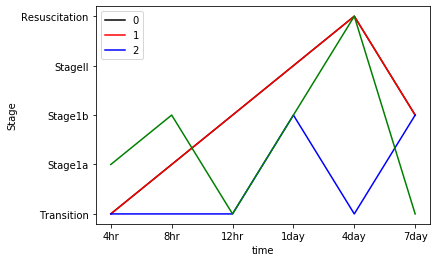

In [27]:
_, ax = plt.subplots(1)
repl_dct[-1] = ["Transition", "Stage1a", "Stage1b", "StageII", "Resuscitation"]
repl_dct[-1] = repl_dct[0]
repl_dct[-1][0] = "Transition"
repl_dct[-1][1] = "Stage1a"
repl_dct[-1][2] = "Stage1b"
repl_dct[-1][3] = "StageII"
repl_dct[-1][4] = "Resuscitation"
colors = ["red", "blue", "green"]
for repl in range(-1, 3):
    if repl == -1:
        color = "black"
    else:
        color = colors[repl]
    ax.plot(truncated_time_keys, repl_dct[repl], color=color)
plt.legend([0, 1, 2], loc="upper left")
plt.xlabel("time")
plt.ylabel("Stage")

## AM, MDM

In [28]:
SAMPLE_BIOREACTOR_REF_DCT["AM_MDM"]

,Rv0001,Rv0005,Rv0006,Rv0009,Rv0010c,Rv0011c,Rv0013,Rv0014c,Rv0016c,Rv0020c,...,Rvnt36,Rvnt37,Rvnt38,Rvnt39,Rvnt40,Rvnt41,Rvnt42,Rvnt43,Rvnt44,Rvnt45
AM_D20_1,0,1,0,0,-1,1,0,0,0,0,...,-1,1,-1,0,-1,-1,-1,-1,-1,-1
AM_D20_3,0,1,0,0,-1,1,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
AM_D20_4,0,1,0,0,-1,1,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
AM_D20_5,0,1,0,0,-1,1,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
MDM_D20_1,1,0,0,0,-1,1,0,0,0,0,...,-1,0,-1,-1,-1,-1,-1,-1,-1,-1
MDM_D20_3,0,1,0,0,-1,1,0,0,0,0,...,-1,-1,-1,-1,0,-1,-1,-1,-1,-1
MDM_D20_4,1,0,1,0,-1,1,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
MDM_D20_5,0,1,1,-1,-1,1,-1,0,-1,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


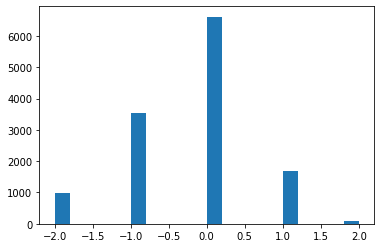

In [29]:
df = SAMPLE_BIOREACTOR_REF_DCT["AM_MDM"] - SAMPLE_NOTBIOREACTOR_REF_DCT["AM_MDM"]
df = df.T.dropna(axis=1, how='all').T
_ = plt.hist(df.values.flatten(), bins=20)

## Galagan

In [30]:
**TODO**: Plot progression of replications over time

SyntaxError: invalid syntax (<ipython-input-30-40bf9f7731a7>, line 1)